# Historical monitor plotting
<!-- markdownlint-disable MD013 -->
Plotting historical triggers based on historical forecasts

In [166]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [258]:
import ocha_stratus as stratus
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from src.datasources import ibtracs
from src.datasources.ibtracs import knots2cat
from src.constants import *

## Load and merge data

In [182]:
df_storms = ibtracs.load_storms()
cols = ["sid", "atcf_id", "name"]
df_storms = df_storms[
    (df_storms["sid"].str[:4].astype(int) >= 2000)
    & (df_storms["genesis_basin"] == "NA")
][cols]
df_storms["atcf_id"] = df_storms["atcf_id"].str.lower()

In [183]:
df_storms

,sid,atcf_id,name
10887,2000160N21267,al012000,UNNAMED
10891,2000175N09340,al022000,UNNAMED
10907,2000217N11342,al032000,ALBERTO
10911,2000222N28286,al042000,UNNAMED
10914,2000227N23267,al052000,BERYL
...,...,...,...
13399,2024293N17275,al152024,NADINE
13400,2024293N21294,al162024,OSCAR
13404,2024306N39319,al172024,PATTY
13408,2024309N13283,al182024,RAFAEL


In [173]:
df_storms

,sid,name,atcf_id
1853,2000160N21267,UNNAMED,al012000
1854,2000175N09340,UNNAMED,al022000
1855,2000217N11342,ALBERTO,al032000
1856,2000222N28286,UNNAMED,al042000
1857,2000227N23267,BERYL,al052000
...,...,...,...
2299,2024293N17275,NADINE,al152024
2300,2024293N21294,OSCAR,al162024
2301,2024306N39319,PATTY,al172024
2302,2024309N13283,RAFAEL,al182024


In [184]:
blob_name = f"{PROJECT_PREFIX}/processed/impact/emdat_cerf_upto2024.parquet"
df_impact = stratus.load_parquet_from_blob(blob_name)
df_impact["cerf"] = ~df_impact["Amount in US$"].isnull()
cols = [
    "sid",
    "cerf",
    "Total Affected",
    "Total Deaths",
    "Total Damage, Adjusted ('000 US$)",
    "Amount in US$",
]
df_impact = df_impact[cols]

In [185]:
df_impact.loc[df_impact["sid"] == IKE, "Total Affected"] = 2.6e6

In [186]:
blob_name = blob_name = (
    f"{PROJECT_PREFIX}/processed/nhc/monitors_nhc_chirpsgefs.parquet"
)
df_monitors = stratus.load_parquet_from_blob(blob_name)

In [187]:
df_monitors_max = (
    df_monitors.groupby(["atcf_id", "lt_name"]).max().reset_index().dropna()
)

In [188]:
df_monitors_max

,atcf_id,lt_name,mean,q50,q80,q90,q95,q99,issue_time,wind
0,al012005,action,52.950157,47.856190,71.045200,91.562890,115.904170,149.363820,2005-06-10 12:00:00,50.0
1,al012005,readiness,52.950157,47.856190,71.045200,91.562890,115.904170,149.363820,2005-06-10 12:00:00,50.0
2,al012006,action,33.027378,8.143184,70.166730,114.015564,131.700010,168.528820,2006-06-10 18:00:00,35.0
3,al012006,readiness,33.027378,8.143184,70.166730,114.015564,131.700010,168.528820,2006-06-10 18:00:00,35.0
4,al012018,action,40.805096,37.670723,71.063400,89.553856,99.458090,118.189415,2018-05-27 00:00:00,45.0
...,...,...,...,...,...,...,...,...,...,...
159,al282005,readiness,1.724343,0.803031,3.099219,5.081104,6.967461,10.931944,2005-11-20 00:00:00,45.0
160,al282020,action,35.723633,33.662880,58.217728,66.597960,70.594090,84.447070,2020-10-25 00:00:00,50.0
161,al282020,readiness,35.723633,33.662880,58.217728,66.597960,70.594090,84.447070,2020-10-25 00:00:00,50.0
162,al292020,action,53.343884,47.353573,81.116745,100.764730,116.072280,175.455220,2020-11-11 00:00:00,65.0


In [189]:
df_monitors_max["year"] = df_monitors_max["atcf_id"].str[-4:].astype(int)

In [190]:
n_years = (
    df_monitors_max["issue_time"].max().year
    - df_monitors_max["issue_time"].min().year
    + 1
)

In [191]:
target_rps = {
    "action": 3.7,
    "readiness": 3,
}

In [192]:
target_trig_years = {
    lt_name: int((n_years + 1) / rp) for lt_name, rp in target_rps.items()
}

In [193]:
target_trig_years

{'action': 7, 'readiness': 8}

In [194]:
lt_name = "action"
df_stats = (
    df_monitors_max[df_monitors_max["lt_name"] == lt_name]
    .merge(df_storms, how="left")
    .merge(df_impact, how="left")
)
df_stats

,atcf_id,lt_name,mean,q50,q80,q90,q95,q99,issue_time,wind,year,sid,name,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$
0,al012005,action,52.950157,47.856190,71.045200,91.562890,115.904170,149.363820,2005-06-10 12:00:00,50.0,2005,2005160N17276,ARLENE,NaN,NaN,NaN,NaN,NaN
1,al012006,action,33.027378,8.143184,70.166730,114.015564,131.700010,168.528820,2006-06-10 18:00:00,35.0,2006,2006161N20275,ALBERTO,False,268.0,NaN,NaN,NaN
2,al012018,action,40.805096,37.670723,71.063400,89.553856,99.458090,118.189415,2018-05-27 00:00:00,45.0,2018,2018146N19273,ALBERTO,False,40000.0,9.0,NaN,NaN
3,al012022,action,36.127280,17.138527,75.981980,98.452230,110.067380,132.969360,2022-06-03 18:00:00,35.0,2022,2022154N21273,ALEX,False,6780.0,3.0,NaN,NaN
4,al022009,action,13.270083,11.928123,18.099740,24.026773,29.061850,39.484074,2009-08-17 12:00:00,30.0,2009,2009222N14336,ANA,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,al262005,action,11.827251,7.242763,14.412372,22.866184,47.838630,96.984566,2005-10-23 18:00:00,35.0,2005,2005296N16293,ALPHA,NaN,NaN,NaN,NaN,NaN
67,al262020,action,19.399986,18.416336,27.778313,33.853030,42.064130,55.219050,2020-10-05 18:00:00,105.0,2020,2020279N16284,DELTA,NaN,NaN,NaN,NaN,NaN
68,al282005,action,1.724343,0.803031,3.099219,5.081104,6.967461,10.931944,2005-11-20 00:00:00,45.0,2005,2005318N13298,GAMMA,NaN,NaN,NaN,NaN,NaN
69,al282020,action,35.723633,33.662880,58.217728,66.597960,70.594090,84.447070,2020-10-25 00:00:00,50.0,2020,2020299N18277,ZETA,NaN,NaN,NaN,NaN,NaN


## Comparing options

In [201]:
f"{6**2 * 70**6:,}"

'4,235,364,000,000'

In [202]:
f"{6**2 * 70**4:,}"

'864,360,000'

In [236]:
df_stats["cat"] = df_stats["wind"].apply(knots2cat)

In [237]:
df_stats["cerf_num"] = df_stats["cerf"].apply(lambda x: 1 if x == True else 0)

In [238]:
df_stats[df_stats["Total Affected"] > 0].corr(numeric_only=True)[
    "Total Affected"
]

mean                                 0.457473
q50                                  0.555292
q80                                  0.342930
q90                                  0.171112
q95                                  0.038959
q99                                 -0.103167
wind                                 0.420111
year                                 0.146398
Total Affected                       1.000000
Total Deaths                         0.274627
Total Damage, Adjusted ('000 US$)   -0.212292
Amount in US$                        0.714876
Total Affected sq                    0.937354
cat                                  0.475866
cerf_num                             0.380501
Name: Total Affected, dtype: float64

In [239]:
df_stats["Total Affected sq"] = df_stats["Total Affected"] ** 2

In [240]:
df_stats.corr(numeric_only=True)["Total Affected sq"]

mean                                 0.450597
q50                                  0.532209
q80                                  0.388422
q90                                  0.255958
q95                                  0.137799
q99                                 -0.018354
wind                                 0.355466
year                                 0.137416
Total Affected                       0.937354
Total Deaths                         0.237446
Total Damage, Adjusted ('000 US$)   -0.216323
Amount in US$                        0.623100
Total Affected sq                    1.000000
cat                                  0.396723
cerf_num                             0.305542
Name: Total Affected sq, dtype: float64

Above checks correlation with impact to get rough idea of what rainfall aggregation could be good. Maybe the median?

In [241]:
rain_cols = [x for x in df_stats.columns if "q" in x or x == "mean"]

In [242]:
df_stats[df_stats["cerf"] == True][
    ["name", "Total Affected"] + rain_cols
].sort_values("Total Affected", ascending=False).style.background_gradient(
    cmap="Reds",  # use a colormap where higher = darker
    axis=0,  # apply column-wise normalization
)

,name,Total Affected,mean,q50,q80,q90,q95,q99,Total Affected sq
40,IRMA,10000000.000000,96.329570,101.040480,142.671460,176.874760,201.250240,223.792560,100000000000000.000000
61,RAFAEL,4000000.000000,26.405380,22.381561,39.929104,57.517890,67.368840,99.797450,16000000000000.000000
33,IAN,3200000.000000,46.000458,41.205720,76.098890,122.395470,139.612880,168.837500,10240000000000.000000
28,IKE,2600000.000000,101.455860,94.025665,128.088730,148.913330,177.149400,212.406570,6760000000000.000000
22,GUSTAV,450019.000000,59.768433,46.652534,103.080360,120.162820,141.738710,196.892400,202517100361.000000
53,OSCAR,320000.000000,21.936502,7.418959,38.042336,70.525900,108.399750,204.140690,102400000000.000000
45,MATTHEW,190000.000000,54.863920,26.405437,81.510660,153.609340,241.607300,323.787080,36100000000.000000
59,SANDY,162605.000000,71.266540,36.475723,133.004680,204.276820,263.916200,437.836200,26440386025.000000


Plot above compares relative severity of different rainfall aggregations for each storm. Unfortunately, Oscar isn't the "worst" for any of them, and Rafael isn't even close.

In [243]:
cat2knots = {5: 137, 4: 113, 3: 96, 2: 83, 1: 64}

In [251]:
# iterate over categories to get the appropriate rainfall threshold for each one
rain_col = "q80"

rain_threshs = {}
for cat in [1, 2, 3, 4]:
    df_stats_cat = df_stats[df_stats["cat"] >= cat].sort_values(
        rain_col, ascending=False
    )
    rain_thresh = None
    for check_thresh in df_stats_cat[rain_col]:
        dff = df_stats_cat[df_stats_cat[rain_col] >= check_thresh]
        if dff["year"].nunique() > 7:
            break
        rain_thresh = check_thresh

    rain_thresh = (rain_thresh + check_thresh) / 2

    rain_threshs.update({cat: rain_thresh})

In [252]:
rain_threshs

{1: 85.40447499999999, 2: 82.28268, 3: 77.151055, 4: 35.698547}

## Plotting

Plotting rain vs. wind for historical storms, with rain threshold set to get correct return period from a wind threshold fixed at a Category level.

In [253]:
def plot_threshs(rain_thresh, wind_cat_thresh, rain_col):
    wind_thresh = cat2knots[wind_cat_thresh]
    ymax = df_stats[rain_col].max() * 1.1
    xmax = df_stats["wind"].max() * 1.1

    fig, ax = plt.subplots(dpi=200, figsize=(7, 7))

    bubble_sizes = df_stats["Total Affected"].fillna(0)
    # Optional: scale for visual clarity
    bubble_sizes_scaled = (
        bubble_sizes / bubble_sizes.max() * 5000
    )  # Adjust 300 as needed

    # Plot bubbles
    ax.scatter(
        df_stats["wind"],
        df_stats[rain_col],
        s=bubble_sizes_scaled,
        alpha=0.3,
        color="crimson",
        edgecolor="none",
        zorder=1,
    )

    for _, row in df_stats.iterrows():
        triggered = (row[rain_col] >= rain_thresh) & (
            row["wind"] >= wind_thresh
        )
        ax.annotate(
            row["name"].capitalize() + "\n" + str(row["year"]),
            (row["wind"], row[rain_col]),
            ha="center",
            va="center",
            fontsize=6,
            color="crimson" if row["cerf"] == True else "k",
            zorder=10 if row["cerf"] else 9,
            alpha=0.8,
            fontstyle="italic" if triggered else "normal",
            fontweight="bold" if triggered else "normal",
        )

    trig_color = "orange"
    ax.axvline(
        wind_thresh,
        color=trig_color,
        linewidth=0.5,
        zorder=0,
    )
    ax.annotate(
        f"  Cat. {wind_cat_thresh} \n({wind_thresh} kn) ",
        (wind_thresh, 0),
        va="top",
        ha="center",
        rotation=90,
        color=trig_color,
        fontsize=8,
        fontstyle="italic",
    )
    ax.axhline(
        rain_thresh,
        color=trig_color,
        linewidth=0.5,
        zorder=0,
    )
    ax.annotate(
        f"{rain_thresh:.0f} mm",
        (0, rain_thresh),
        va="center",
        ha="right",
        color=trig_color,
        fontsize=8,
        fontstyle="italic",
    )
    ax.add_patch(
        mpatches.Rectangle(
            (wind_thresh, rain_thresh),  # bottom left
            xmax - wind_thresh,  # width
            ymax - rain_thresh,  # height
            facecolor=trig_color,
            alpha=0.07,
            zorder=0,
        )
    )

    ax.annotate(
        "\n"
        "    Size of bubble corresponds to\n"
        "    total number of people affected [EM-DAT]\n\n"
        "    Red text indicates CERF allocation",
        (0, ymax),
        va="top",
        fontsize=6,
        fontstyle="italic",
        color="grey",
    )
    ax.annotate(
        "\n    Triggered    \n    storms    ",
        (wind_thresh, ymax),
        ha="left",
        va="top",
        color=trig_color,
        fontstyle="italic",
    )

    if rain_col == "q50":
        ylabel = (
            "Two-day rainfall, median over whole country (mm) [CHIRPS-GEFS]"
        )
    else:
        ylabel = rain_col
    ax.set_ylabel(ylabel)
    ax.set_xlabel("\nMax. wind speed while in 250 km buffer (knots) [NHC]")
    ax.set_title(
        "Cuba triggered storms based on forecasts (since 2000)\n"
        f"Cat. {cat} and {rain_thresh:.0f} mm rainfall trigger"
    )

    ax.set_xlim(left=0, right=xmax)
    ax.set_ylim(bottom=0, top=ymax)

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    return fig, ax

(<Figure size 1400x1400 with 1 Axes>,
 <Axes: title={'center': 'Cuba triggered storms based on forecasts (since 2000)\nCat. 1 and 85 mm rainfall trigger'}, xlabel='\nMax. wind speed while in 250 km buffer (knots) [NHC]', ylabel='q80'>)

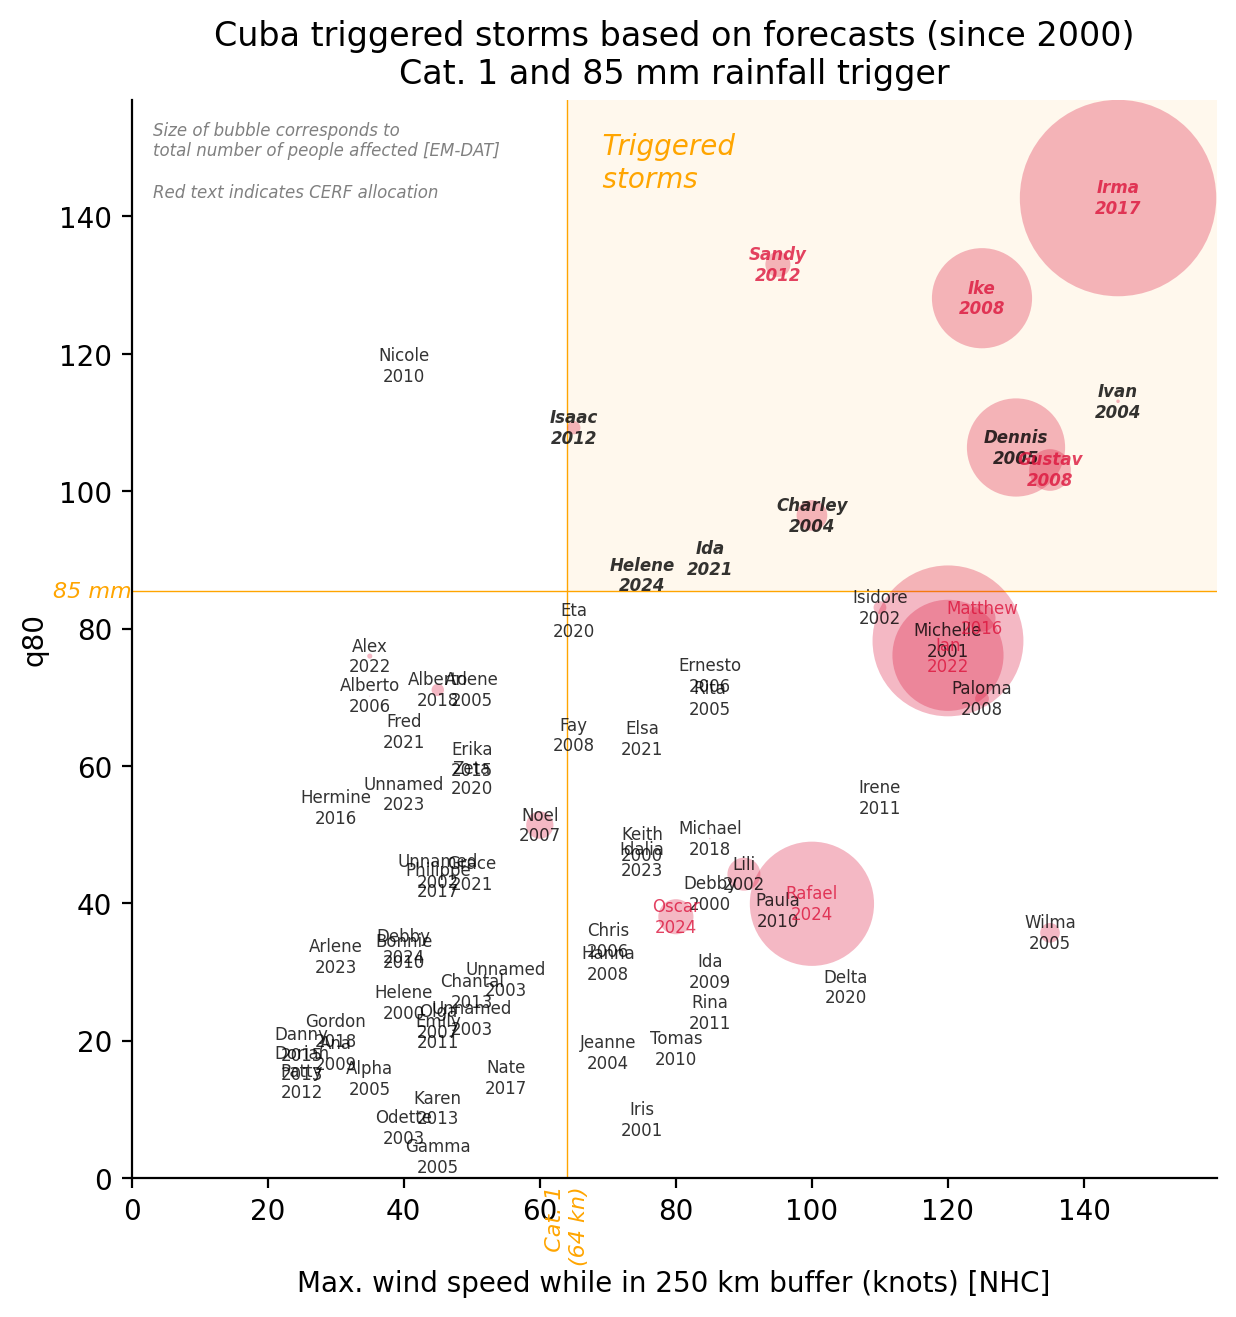

In [254]:
cat = 1
plot_threshs(rain_threshs[cat], cat, rain_col)

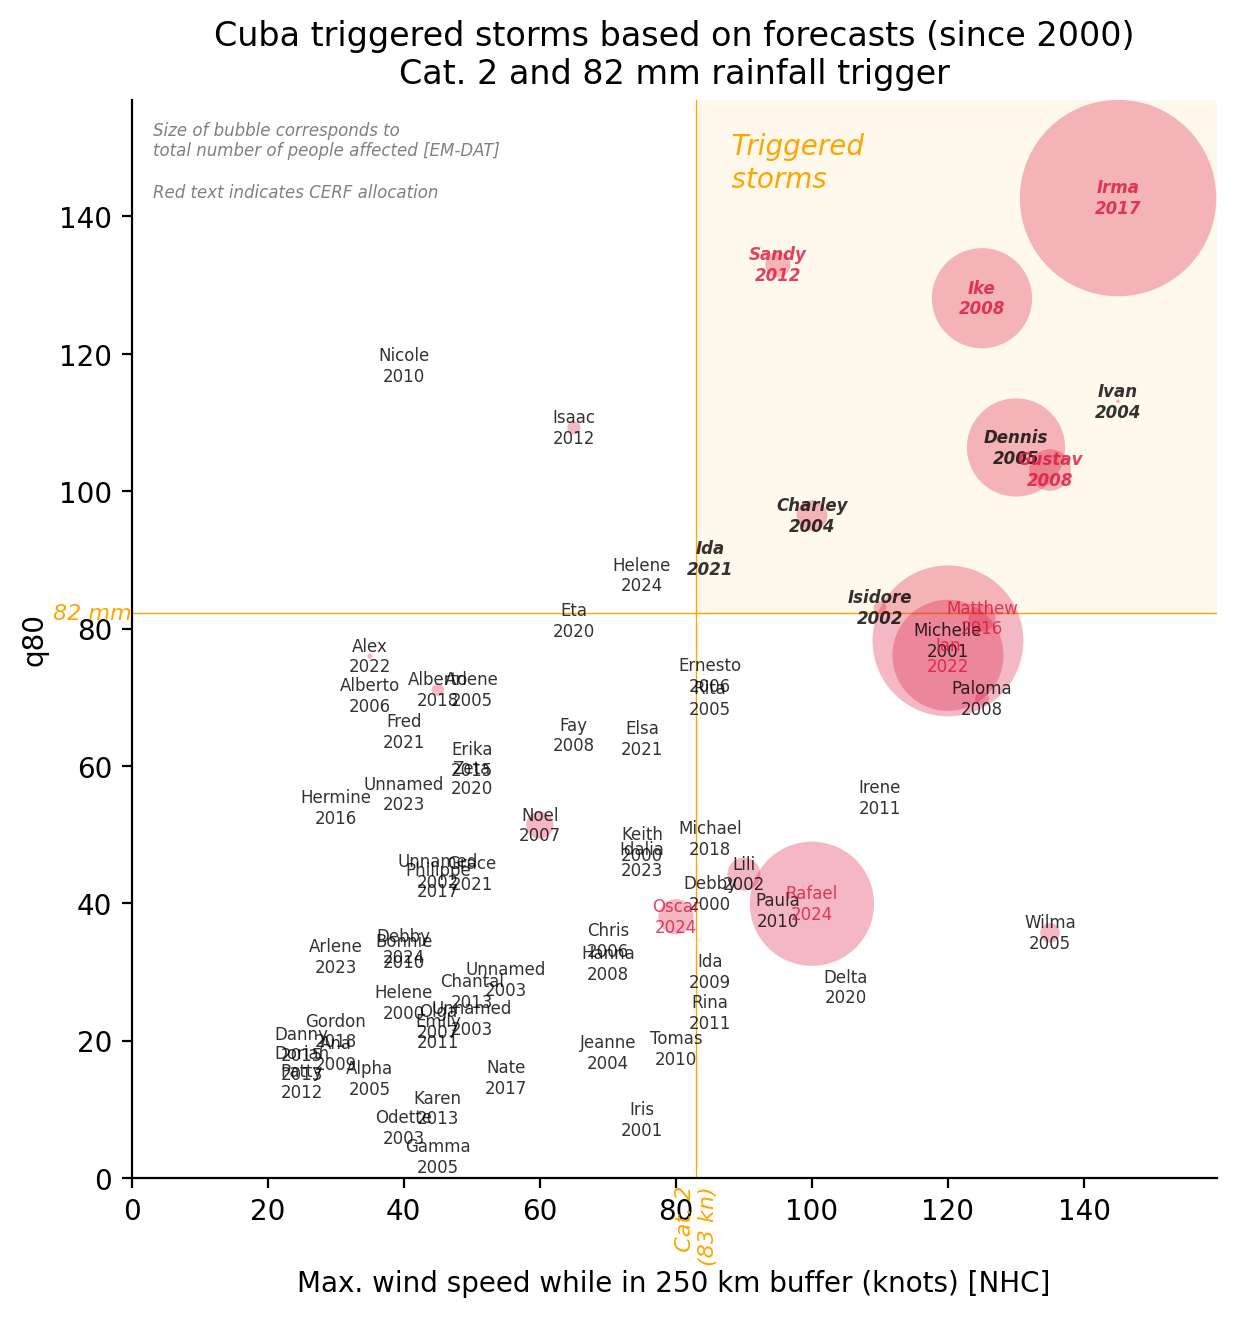

In [255]:
cat = 2
fig, ax = plot_threshs(rain_threshs[cat], cat, rain_col)

(<Figure size 1400x1400 with 1 Axes>,
 <Axes: title={'center': 'Cuba triggered storms based on forecasts (since 2000)\nCat. 3 and 77 mm rainfall trigger'}, xlabel='\nMax. wind speed while in 250 km buffer (knots) [NHC]', ylabel='q80'>)

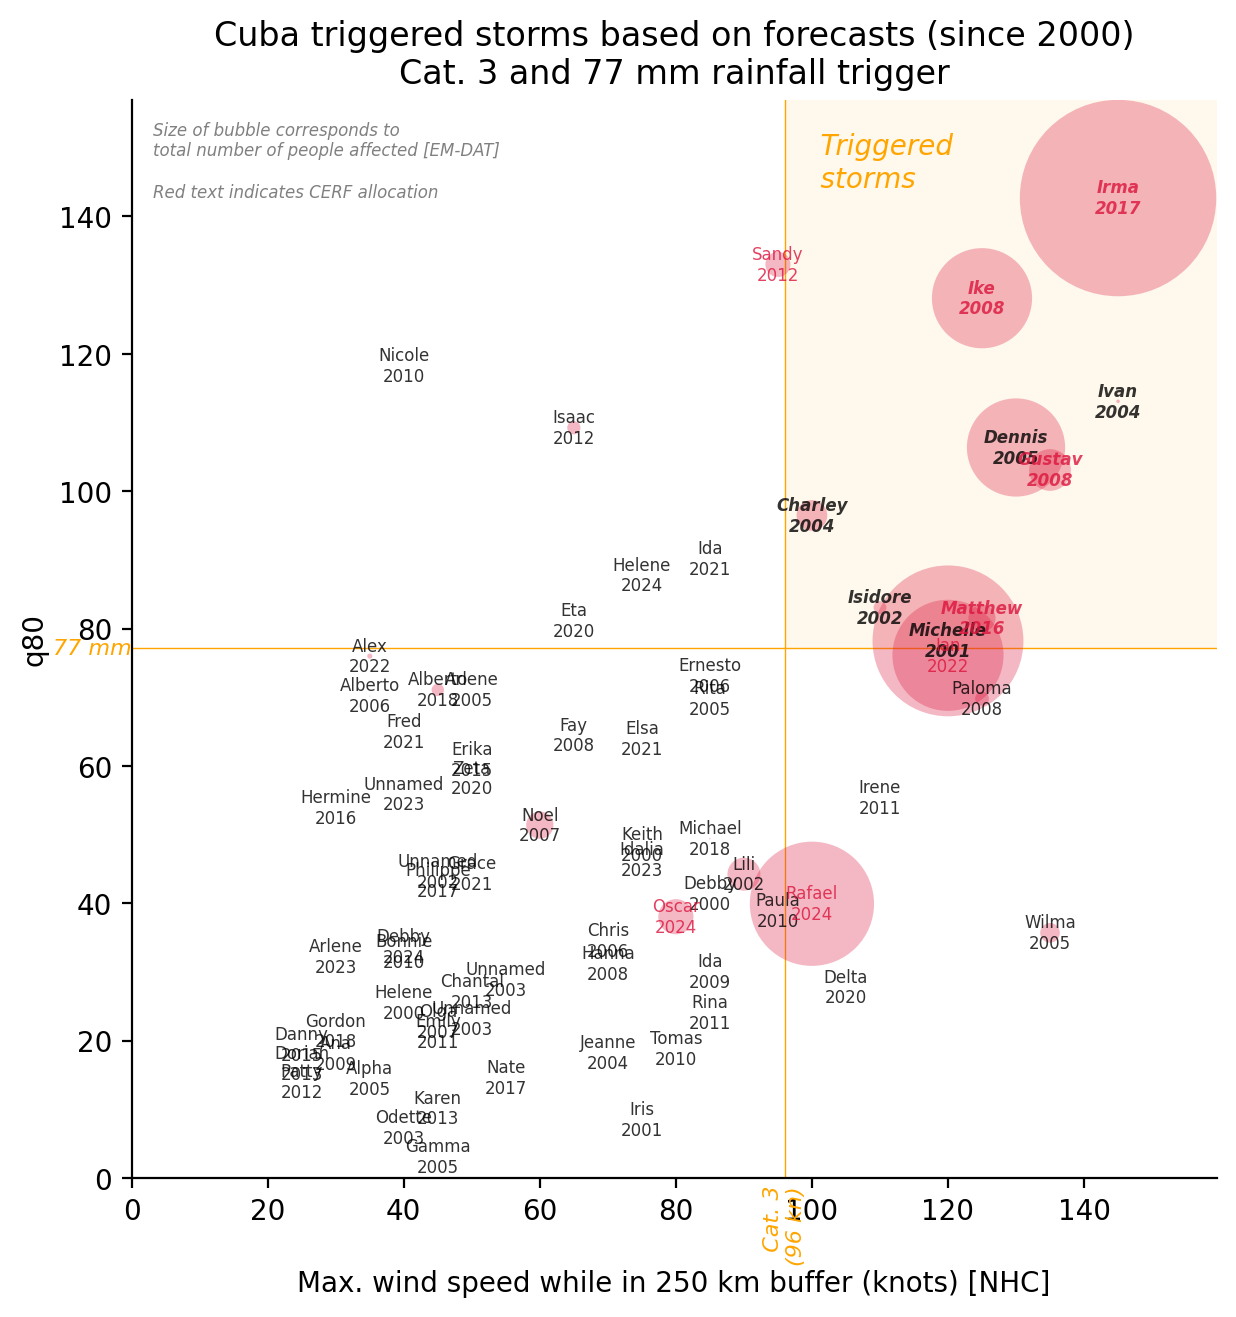

In [256]:
cat = 3
plot_threshs(rain_threshs[cat], cat, rain_col)

(<Figure size 1400x1400 with 1 Axes>,
 <Axes: title={'center': 'Cuba triggered storms based on forecasts (since 2000)\nCat. 4 and 36 mm rainfall trigger'}, xlabel='\nMax. wind speed while in 250 km buffer (knots) [NHC]', ylabel='q80'>)

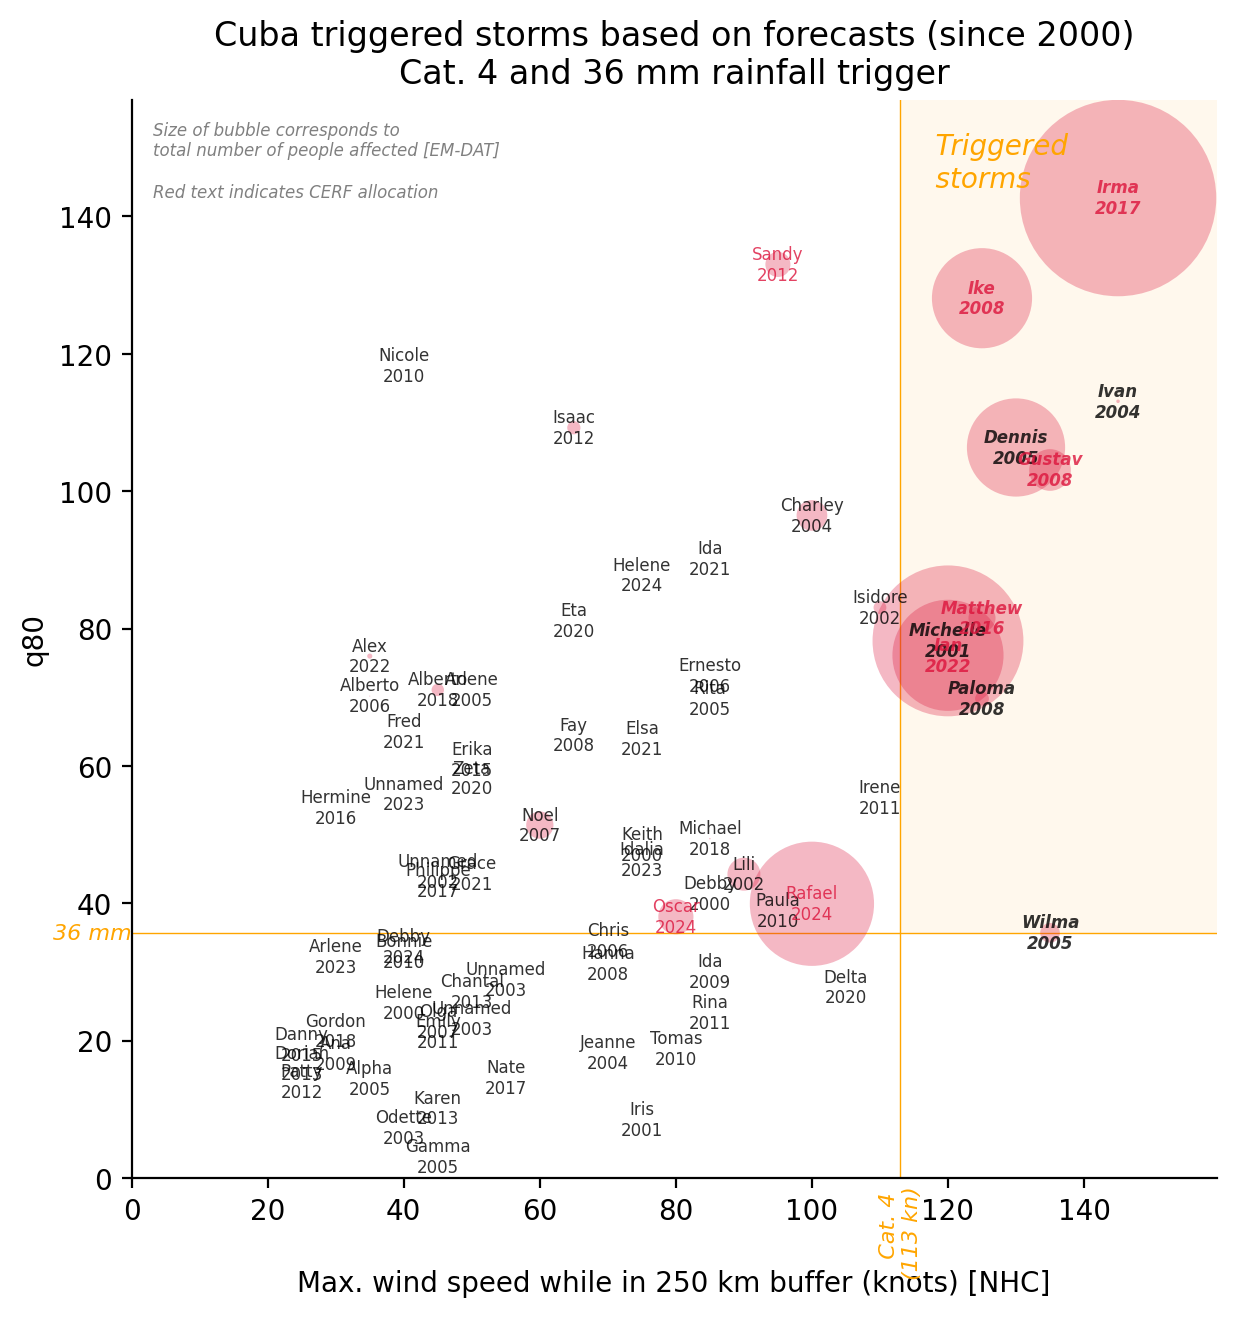

In [257]:
cat = 4
plot_threshs(rain_threshs[cat], cat, rain_col)